In [1]:
import numpy as np
from matplotlib import pylab as plt
import random
import time
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from IPython import display

In [2]:
# Global config 
num_bp = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 10
input_size = 3
output_size = 1
state_size = 4
h1_size = 2
#learning_rate = 0.5
num_mov = 6
max_len_mov = 4
Epochs = 20000

In [3]:
#generate data
def gen_data(size=600):
    X = np.ones(shape=(1,size))
    Y = np.zeros(shape=(1,size))
    n = int(num_mov/100*size)
    idx = 0
    for _ in range(n):
        d_idx = np.random.poisson(lam=10)
        len_mov = np.random.poisson(lam=max_len_mov)
        idx += d_idx
        if np.random.rand()>0.5:
            X[0,idx:idx+len_mov] = 2
        else:
            X[0,idx:idx+len_mov] = 0
        idx += len_mov
        if idx>size:
            break
    for idx in range(size):
        Y[0,idx] = Y[0,idx-1] + X[0,idx] - 1
    return X,Y

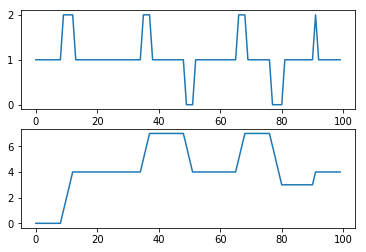

In [4]:
size = 100
X_, Y_ = gen_data(size)
f1 = plt.figure()
plt.subplot(2,1,1)
plt.plot(list(range(size)), X_.T)
plt.subplot(2,1,2)
plt.plot(list(range(size)), Y_.T)
plt.show()

In [5]:
def genBatch(data, batch_size, num_bp):
    data_x, data_y = data
    length = len(data_y[0])
    data_x_batch = np.reshape(data_x[0], [batch_size,-1])
    data_y_batch = np.reshape(data_y[0], [batch_size, -1])
    data_x_step = []
    data_y_step = []
    for ii in range(int(length/num_bp/batch_size)):
        data_x_step.append(data_x_batch[:,ii*num_bp:(ii+1)*num_bp])
        data_y_step.append(data_y_batch[:,ii*num_bp:(ii+1)*num_bp])

    #for ii in range(int(length/batch_size)-num_bp):
     #   data_x_step.append(data_x_batch[:,ii:ii+num_bp])
      #  data_y_step.append(data_y_batch[:,ii:ii+num_bp])
    x,y = list(data_x_step), list(data_y_step)
    
    return x,y

data = gen_data()
x,y = genBatch(data, batch_size, num_bp)
#print(len(x[0]))
#print(y)

In [6]:
trainX = list()
trainY = list()
for i in range(num_bp):
    trainX.append(tf.placeholder(tf.float32, shape=(batch_size, input_size)))
    
    trainY.append(tf.placeholder(tf.float32, shape=(batch_size, output_size)))
state_first = tf.placeholder(tf.float32, shape=(batch_size, state_size), name='1st')
#RNN layer variables
U = tf.Variable(tf.truncated_normal([input_size+state_size, state_size], -0.1, 0.1))
#U = tf.Variable(tf.zeros(shape=[input_size+state_size, state_size]),dtype=tf.float32)
#W = tf.Variable(tf.truncated_normal([state_size, state_size], -0.1, 0.1))
b = tf.Variable(tf.zeros([1, state_size]))

#output layer variables
"""V = tf.Variable(tf.truncated_normal([state_size, output_size], -0.1, 0.1))
#V = tf.Variable(tf.zeros([state_size, output_size]), dtype=tf.float32)
c = tf.Variable(tf.zeros([batch_size, output_size]))"""
W1 = tf.Variable(tf.truncated_normal([state_size, h1_size], -0.1, 0.1))
b1 = tf.Variable(tf.zeros([batch_size, h1_size]))
Wo = tf.Variable(tf.truncated_normal([h1_size, output_size], -0.1, 0.1))
bo = tf.Variable(tf.zeros([batch_size, output_size]))

#model
def RNN(x, state_pre):
    #a = tf.concat([tf.matmul(x, U), tf.matmul(state_pre, W)], axis=1) + b
    a = tf.matmul(tf.concat([x, state_pre], axis=1), U) + b
    state = tf.nn.softmax(a)
    #o_out = tf.matmul(state, V) + c
    
    h1 = tf.matmul(state, W1) + b1
    o_out = tf.matmul(tf.nn.softmax(h1), Wo) + bo
    
    return state, o_out


for i in range(num_bp):
    if i == 0:
        outputs = list()
        state_after, output_after = RNN(trainX[i], state_first)
    else:
        state_after, output_after = RNN(trainX[i], state_pre)
    state_pre = state_after
    outputs.append(output_after)

In [7]:
#train

#log likelihood loss
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.concat(outputs,0),labels=tf.concat(trainY,0)))
loss = tf.losses.mean_squared_error(labels=tf.concat(trainY,0), predictions = tf.concat(outputs,0))
learning_rate = tf.placeholder(tf.float32, shape=[])

#optimizer
global_epoch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    learning_rate=1.0, global_step=global_epoch, decay_steps=2000, decay_rate=0.9, staircase=True)
#learning_rate = 1.0

optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

gradients,var=zip(*optimizer.compute_gradients(loss))
gradients_clipped, _ = tf.clip_by_global_norm(gradients, 1.5)
opt=optimizer.apply_gradients(zip(gradients_clipped,var),global_step=global_epoch)




In [ ]:
#add init op to the graph
init = tf.global_variables_initializer()
size = 200
data = gen_data(size=size)
batch_x, batch_y = genBatch(data, batch_size, num_bp)
steps = len(batch_y)

sess = tf.Session()
sess.run(init)
average_loss_series = list()
outputs_series = list()


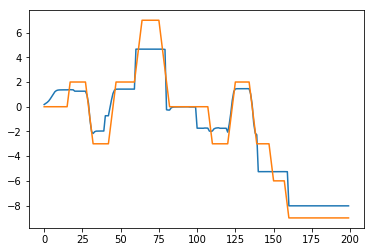

1201/|/  6%|| 1201/20000 [00:33<11:32, 27.16it/s]

Epoch: 1200 Average Loss: 1.01886665821


In [ ]:
average_loss_series = list()
outputs_series = list()
pbar = tqdm(total=Epochs)
for epoch in range(Epochs):
    if epoch%50 == 0:
        plot_y = np.zeros([batch_size, int(size/batch_size)])
    for step in range(steps):
        
        average_loss = list()
        #initialize the output
        if step == 0:
            if epoch == 0:
                output_pass = np.zeros([batch_size, state_size], dtype=np.float32)
            else:
                output_pass = np.zeros([batch_size, state_size], dtype=np.float32)
                output_pass[1:batch_size,:] = np.asarray(state_after_[0:batch_size-1][:])
        else:
            output_pass = state_after_
        feed_dict={state_first: output_pass}


        #trains x
        for i in range(num_bp):
            batch_x_i = batch_x[step][:,i].astype(int)
            batch_x_i_onehot = np.zeros((len(batch_x_i), input_size))
            batch_x_i_onehot[range(len(batch_x_i)), batch_x_i] = 1
            feed_dict[trainX[i]] = batch_x_i_onehot

            batch_y_i = np.reshape(batch_y[step][:,i],[batch_size,1])
            feed_dict[trainY[i]] = batch_y_i
        
        feed_dict[learning_rate] = 1.0
        
        state_after_, l ,outputs_, _ = sess.run([state_after, loss, outputs, opt], feed_dict=feed_dict)
        outputs_series.append(outputs_)
        average_loss.append(l)
        ave_loss = sum(average_loss)/float(len(average_loss))
        
        #if epoch%50 == 0:
         #   plot_y[:, step] = outputs_[0].reshape([batch_size])
    #if epoch%50 == 0:
     #       plot_y[:, steps:int(size/batch_size)] = np.asarray(outputs_).reshape([batch_size, num_bp])   
        
        if epoch%100 == 0:
            plot_y[:, step*num_bp:(step+1)*num_bp] = np.asarray(outputs_).flatten().reshape([-1,batch_size]).T #np.asarray(outputs_).reshape([batch_size, num_bp])
            
            
    
    pbar.update(1)
    if epoch%100 == 0:
        display.clear_output(wait=True)
        f2 = plt.figure()
        plt.plot(plot_y.reshape([-1]),label='Preiction')
        plt.plot(data[1][0],label='Real')
        display.display(plt.gcf())
        display.display(pbar)
        print ('Epoch: ' +str(epoch) + ' Average Loss: '+str(ave_loss))
        time.sleep(0.01)        
        
    average_loss_series.append(ave_loss)
    global_epoch += 1
pbar.close()

In [ ]:
f2.savefig('RandomWalk.png')

f1 = plt.figure()
plt.plot(average_loss_series)
plt.show(f1)

f2 = plt.figure()
plt.plot(plot_y.reshape([-1]),label='Preiction')
plt.plot(data[1][0],label='Real')
plt.legend()
plt.show()